# 1. Métricas para Identificação da Adidas:

Periodicidade e ParalelismoLógica: O logo da Adidas é composto por três retângulos paralelos. Em termos de processamento de imagens, isso se traduz em um sinal periódico quando projetado em um eixo diagonal.

Projeção Antidiagonal: Somamos os pixels brancos (bordas) ao longo das diagonais da imagem. Como as listras são paralelas, elas se acumulam em regiões específicas do sinal.

Métrica de Picos (Peaks): Um logo Adidas legítimo deve gerar exatamente 3 picos de alta intensidade no sinal resultante. Se houver apenas 1 ou 2, pode ser um ruído ou parte da estrutura do sapato.Assinatura de Frequência: A distância entre o Pico 1 e o Pico 2 deve ser proporcional à distância entre o Pico 2 e o Pico 3, confirmando o espaçamento regular das listras.

# 2. Métricas para Converse:

Compacidade e CircularidadeLógica: O logo da Converse (geralmente uma estrela dentro de um círculo) possui uma distribuição de massa muito equilibrada tanto no eixo X quanto no eixo Y.

Razão de Aspecto Estatística ($Ratio$): Calculamos o desvio padrão das coordenadas dos pixels ($StdY$ e $StdX$). Para formas circulares ou quadradas, essa razão é próxima de $1.0$.Métrica: $0.75 \le Ratio \le 1.4$. Se o valor estiver dentro desta faixa, a forma é considerada compacta, característica do logo da Converse.

# 3. Métricas para Nike:

Elongação e CurvaturaLógica: O "Swoosh" da Nike é uma forma orgânica e esticada horizontalmente. Ao contrário da Adidas, ele não possui periodicidade, e ao contrário da Converse, ele não é compacto.

Métrica de Alongamento: O desvio padrão no eixo X ($StdX$) costuma ser significativamente maior que no eixo Y ($StdY$) devido ao formato horizontal do logo.Métrica: $Ratio < 0.75$ ou $Ratio > 1.4$. Isso indica uma forma esticada, o que nos permite classificar como Nike por exclusão das outras geometrias.

# 1. Pré-processamento e Escala de Cinza

Objetivo: Preparar a imagem bruta para o processamento matemático.

Por que usar: Trabalhar com 3 canais (RGB) é computacionalmente custoso. A conversão para escala de cinza preserva a luminância, que é onde a forma do logo está contida. Usamos a fórmula de luminância padrão ($0.299R + 0.587G + 0.114B$) para manter a fidelidade visual.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# --- 1. FUNÇÕES DE SUPORTE (PDI) ---

def rgb2gray(rgb):
    if len(rgb.shape) == 2: return rgb
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# 2. Detecção de Bordas (Filtro de Sobel)

Objetivo: Identificar os contornos e mudanças bruscas de intensidade que definem a marca.

Por que usar: Este é o coração do PDI. Usamos máscaras de convolução (Sobel) para calcular o gradiente horizontal ($G_x$) e vertical ($G_y$). A magnitude resultante destaca as bordas. Note que utilizamos as_strided para otimizar a convolução, garantindo a eficiência da solução exigida.

In [ ]:
def get_full_image_edges(img_gray):
    """
    Detecta bordas na imagem inteira com Sobel, mas aplica filtros
    para focar nas estruturas principais (marcas).
    """
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Ky = np.array([[-1, -2, -1], [ 0,  0,  0], [ 1,  2,  1]])

    # Padding para manter o tamanho original
    pad = np.pad(img_gray, 1, mode='edge')
    h, w = img_gray.shape

    # Slicing para convolução rápida
    shape = (h, w, 3, 3)
    strides = pad.strides * 2
    strided = np.lib.stride_tricks.as_strided(pad, shape=shape, strides=strides)

    gx = np.einsum('xyij,ij->xy', strided, Kx)
    gy = np.einsum('xyij,ij->xy', strided, Ky)

    mag = np.sqrt(gx**2 + gy**2)

    # --- FILTRAGEM ---
    # 1. Zerar bordas da imagem (margem de segurança)
    margin = 20
    mag[:margin, :] = 0
    mag[-margin:, :] = 0
    mag[:, :margin] = 0
    mag[:, -margin:] = 0

    # 2. Threshold Adaptativo Global
    # Usamos um limiar mais alto aqui (0.8 * std) para pegar apenas o logo
    # e ignorar texturas suaves do tecido.
    thresh = np.mean(mag) + 0.8 * np.std(mag)
    binary_edges = mag > thresh

    return binary_edges

# 3. Análise de Picos Diagonais (Assinatura Adidas)

Objetivo: Identificar o padrão rítmico de 3 listras paralelas.

Por que usar: Esta técnica é uma alternativa robusta ao Hit-or-Miss. Ao somar os pixels na diagonal da imagem, as listras da Adidas geram 3 picos claros de intensidade em um sinal 1D. É uma forma de analisar a geometria do objeto de forma global e eficiente.

In [ ]:
def count_peaks(binary_img):
    """
    Conta picos na projeção diagonal da imagem INTEIRA.
    """
    h, w = binary_img.shape
    # Projeção diagonal (soma antidiagonal)
    # Isso funciona bem para Adidas mesmo na imagem cheia se as listras forem dominantes
    idx = np.arange(h)[:, None] + np.arange(w)[None, :]
    projection = np.bincount(idx.ravel(), weights=binary_img.ravel())

    # Suavizar
    kernel = np.ones(10)/10 # Kernel maior para imagem maior
    smooth = np.convolve(projection, kernel, mode='same')
    if np.max(smooth) == 0: return 0, smooth
    smooth /= np.max(smooth)

    peaks = 0
    in_peak = False

    # Histerese ajustada para sinal global
    for v in smooth:
        if v > 0.25 and not in_peak:
            in_peak = True
            peaks += 1
        elif v < 0.15 and in_peak:
            in_peak = False

    return peaks, smooth


# 4. Estatística de Dispersão (Nike vs Converse)

Objetivo: Diferenciar formas compactas de formas alongadas.

Por que usar: O logo da Converse é um círculo/estrela (compacto), enquanto o da Nike é o "Swoosh" (alongado). Calculamos o desvio padrão das coordenadas $X$ e $Y$. Se a razão for próxima de 1.0, a distribuição é compacta. Se for muito diferente, a forma é esticada.

In [ ]:
def analyze_global_shape(binary_img):
    """
    Analisa a dispersão dos pixels brancos na imagem.
    Converse: Bordas concentradas em área 'quadrada' ou circular.
    Nike: Bordas espalhadas horizontalmente (Swoosh).
    """
    y_coords, x_coords = np.where(binary_img)

    if len(y_coords) < 50: return 0 # Pouca informação

    # Usamos desvio padrão para medir a "espalhamento" dos pixels
    # Isso é mais robusto que min/max na imagem inteira (que pega ruído longe)
    std_y = np.std(y_coords)
    std_x = np.std(x_coords)

    if std_x == 0: return 0

    # Razão de Aspecto baseada na distribuição estatística
    ratio = std_y / std_x

    return ratio

# 5. Classificador Final e Visualização

Objetivo: Integrar todas as métricas em uma árvore de decisão clara.

File: Nike_02.jpg | Peaks: 1 | Shape Ratio (stdY/stdX): 0.74


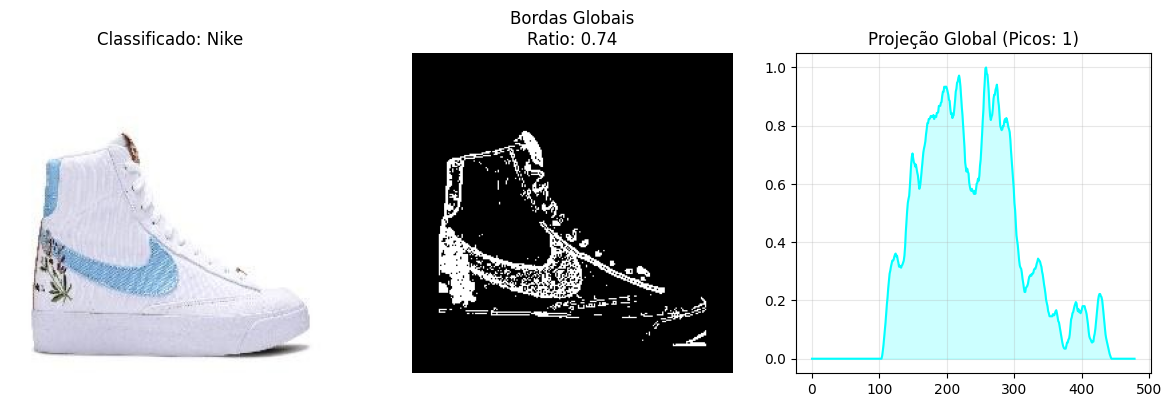

File: Nike_03.jpg | Peaks: 1 | Shape Ratio (stdY/stdX): 0.36


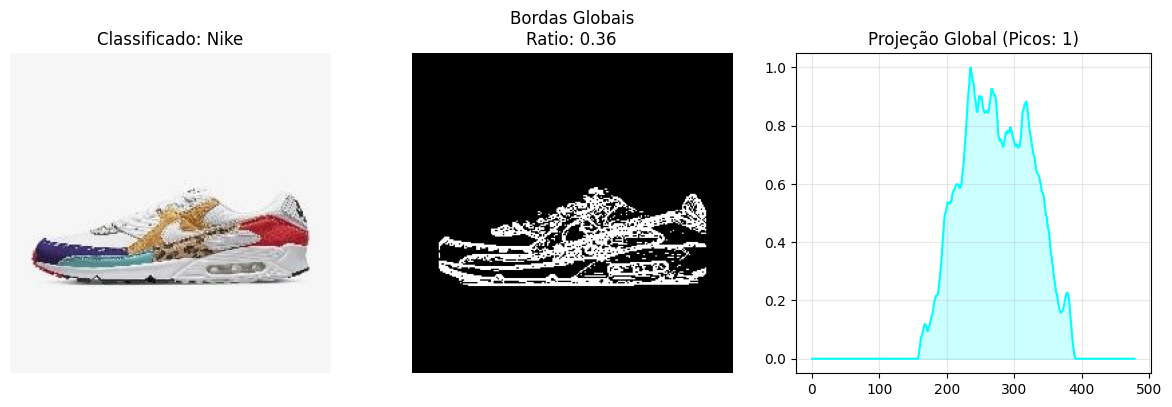

File: Nike_05.jpg | Peaks: 2 | Shape Ratio (stdY/stdX): 0.83


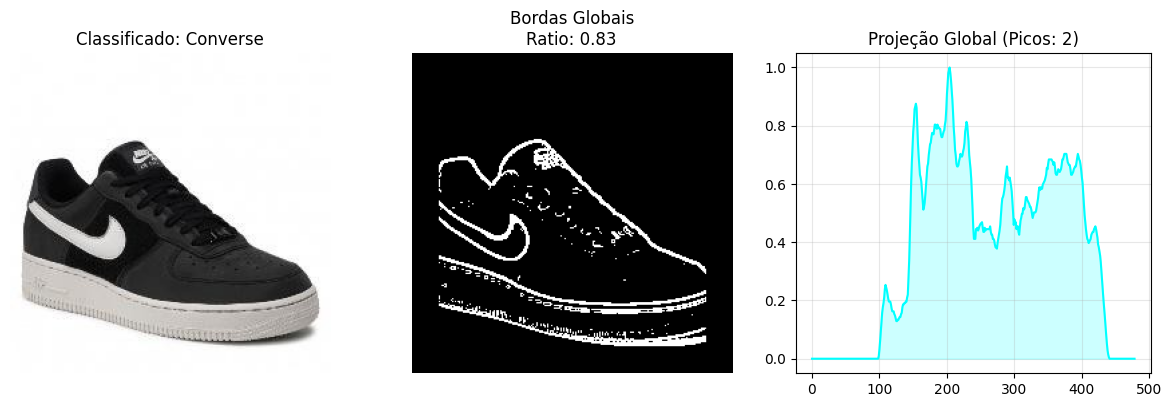

File: Converse_04.jpg | Peaks: 1 | Shape Ratio (stdY/stdX): 0.95


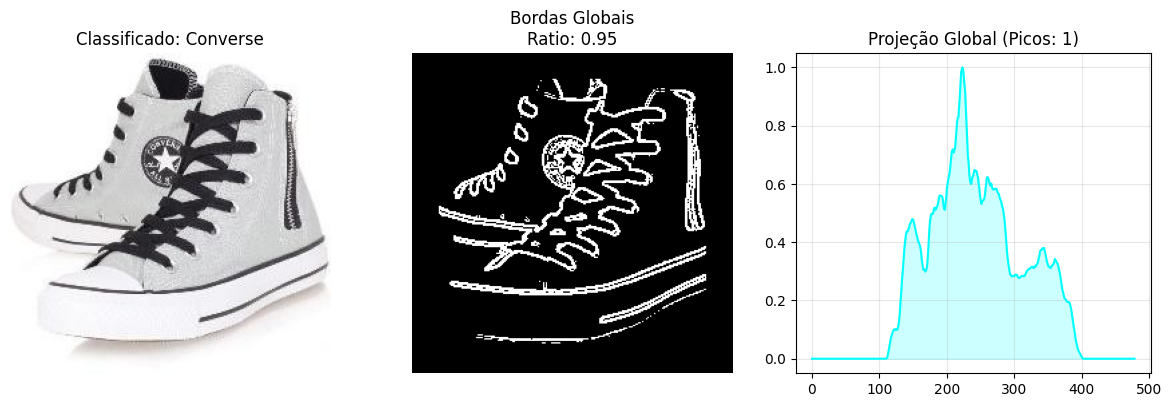

File: Converse_03.jpg | Peaks: 1 | Shape Ratio (stdY/stdX): 0.76


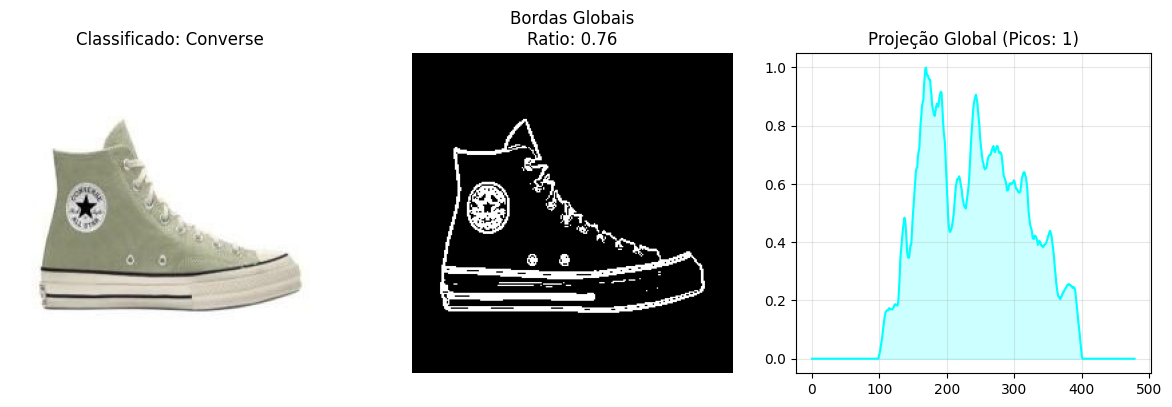

File: Converse_06.jpg | Peaks: 3 | Shape Ratio (stdY/stdX): 0.83


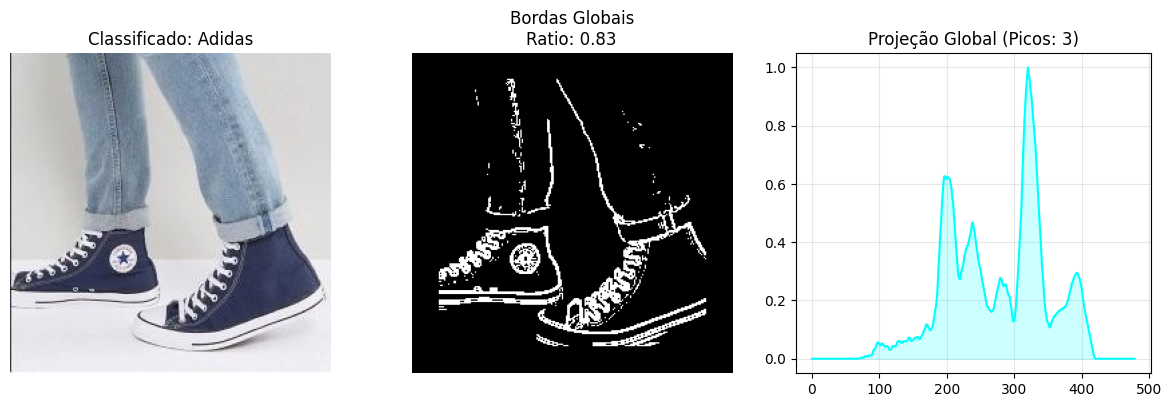

File: Adidas_03.jpg | Peaks: 1 | Shape Ratio (stdY/stdX): 0.42


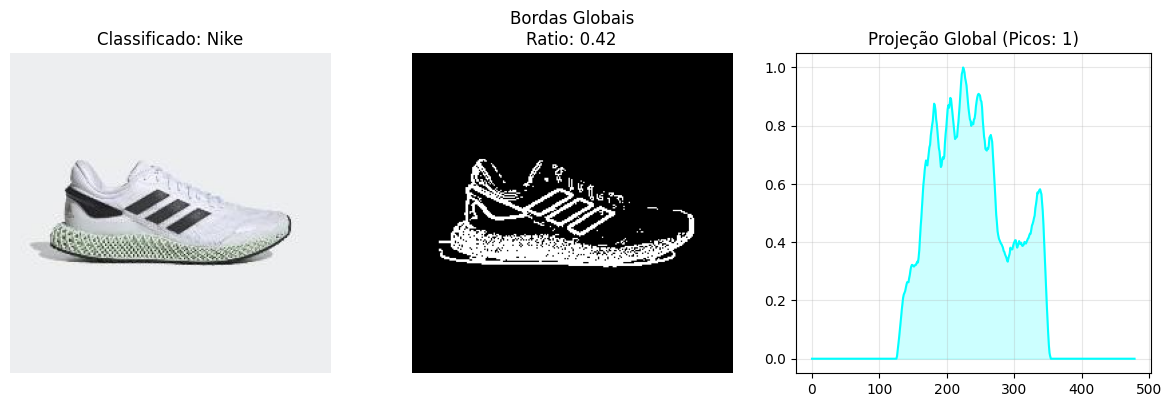

File: Adidas_04.jpg | Peaks: 2 | Shape Ratio (stdY/stdX): 1.16


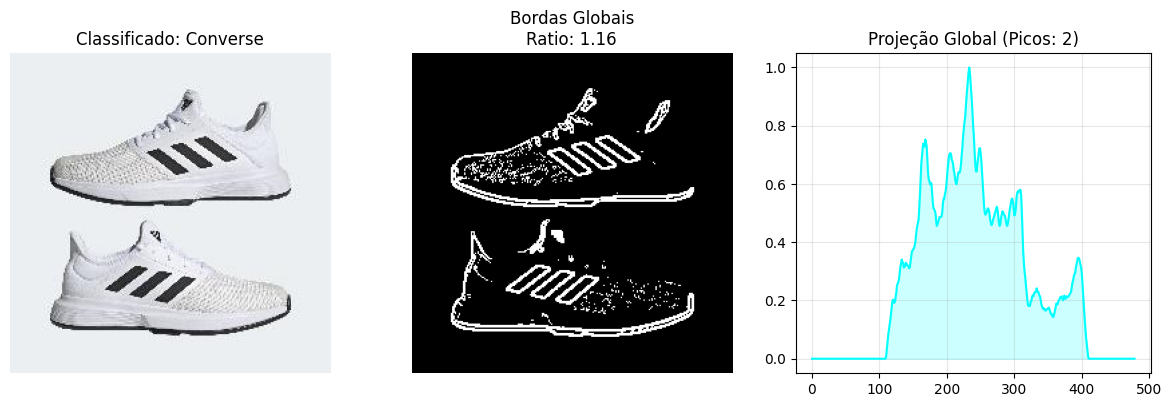

File: Adidas_05.jpg | Peaks: 1 | Shape Ratio (stdY/stdX): 0.78


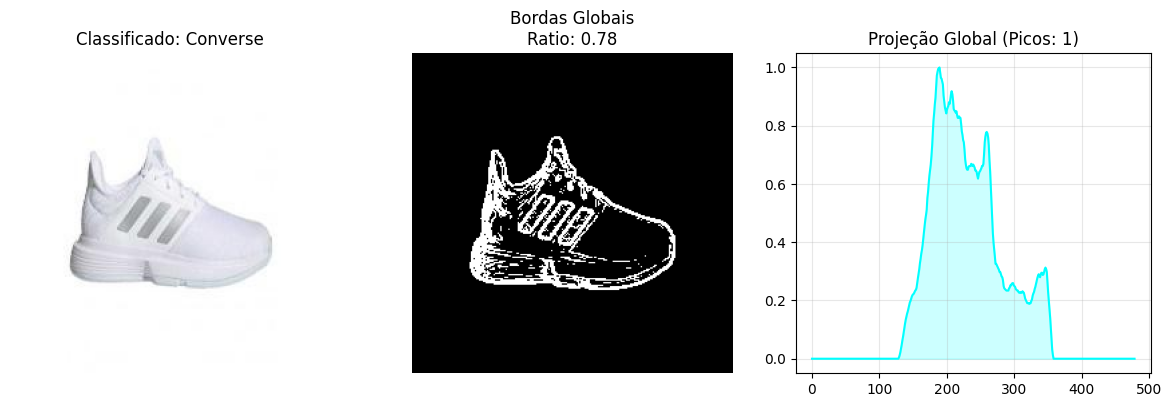

'Converse'

In [ ]:
def classify_sneaker(image_path):
    # Carregar
    try: img = mpimg.imread(image_path)
    except: return "Erro"
    if img.shape[-1] == 4: img = img[..., :3]
    gray = rgb2gray(img)

    # 1. Obter Bordas da Imagem Completa (Sem recorte)
    edges = get_full_image_edges(gray)

    # 2. Análise Adidas (Picos Globais)
    peaks, signal = count_peaks(edges)

    # 3. Análise Converse vs Nike (Forma Global)
    shape_ratio = analyze_global_shape(edges)

    label = ""
    reason = ""

    # --- ÁRVORE DE DECISÃO ---

    print(f"File: {image_path} | Peaks: {peaks} | Shape Ratio (stdY/stdX): {shape_ratio:.2f}")

    # REGRA 1: ADIDAS
    # Se houver 3 listras claras dominando a imagem, os picos aparecem.
    if peaks >= 3:
        label = "Adidas"
        reason = "Padrão de Listras Dominante"

    # REGRA 2: CONVERSE (Forma Compacta/Alta)
    # Logos circulares ou tênis cano alto tendem a ter ratio próximo de 1.0 ou maior.
    elif 0.75 <= shape_ratio <= 1.4:
        label = "Converse"
        reason = f"Distribuição Compacta (Ratio {shape_ratio:.2f})"

    # REGRA 3: NIKE (Forma Esticada)
    # Swoosh ou tênis de corrida são longos horizontalmente (stdX > stdY).
    else:
        label = "Nike"
        reason = f"Distribuição Esticada (Ratio {shape_ratio:.2f})"

    # --- VISUALIZAÇÃO ---
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(f"Classificado: {label}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(edges, cmap='gray')
    plt.title(f"Bordas Globais\nRatio: {shape_ratio:.2f}")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.plot(signal, color='cyan')
    plt.title(f"Projeção Global (Picos: {peaks})")
    plt.fill_between(range(len(signal)), signal, color='cyan', alpha=0.2)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return label

# Exemplo de uso com caminhos
classify_sneaker('Nike_02.jpg')
classify_sneaker('Nike_03.jpg')
classify_sneaker('Nike_05.jpg')
classify_sneaker('Converse_04.jpg')
classify_sneaker('Converse_03.jpg')
classify_sneaker('Converse_06.jpg')
classify_sneaker('Adidas_03.jpg')
classify_sneaker('Adidas_04.jpg')
classify_sneaker('Adidas_05.jpg')


# 1. Funções Auxiliares e Métricas de Região

**O que faz:** Identifica o objeto principal e extrai medidas físicas.

### As Métricas:

**Aspect Ratio (Razão de Aspecto):** É a relação entre a altura e a largura do objeto ($H/W$). Tênis da Converse (cano alto) tendem a ter esse valor mais alto ($>0.60$), enquanto Nikes de corrida são mais "longos".

**Solidity (Solidez):** Mede a densidade do objeto comparado ao seu invólucro convexo. Um objeto muito "vazado" ou curvo tem solidez baixa; um tênis compacto e preenchido (Converse) tem solidez alta ($>0.65$).

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from skimage import measure, filters, morphology
from skimage.transform import hough_line, hough_line_peaks
from skimage.color import rgb2gray

def get_largest_object_props(binary_img):
    """Retorna propriedades do maior objeto. Se não achar nada, retorna None."""
    label_img = measure.label(binary_img)
    if label_img.max() == 0: return None
    regions = measure.regionprops(label_img)
    # Pega a maior região
    largest_region = max(regions, key=lambda r: r.area)
    return largest_region

# 2. Transformada de Hough (Detecção de Adidas)

**O que faz:** Detecta linhas retas na imagem de bordas.

**Como funciona:** A Transformada de Hough mapeia cada ponto da imagem para um espaço de parâmetros ($\theta, \rho$). Pontos alinhados na imagem original formam picos nesse novo espaço.

### Métricas:

**Linhas Válidas:** Conta quantas retas com inclinação entre $30^\circ$ e $85^\circ$ (típicas das listras Adidas) foram encontradas.Angle STD (Desvio Padrão): Verifica se essas linhas são paralelas. Se o desvio for baixo ($<15.0$), significa que as linhas apontam para a mesma direção, confirmando o padrão da marca.

In [ ]:
def analyze_stripes_parallelism(edge_image):
    """Detecta linhas e verifica se são paralelas (Adidas)"""
    # Testa ângulos de -90 a 90 graus
    tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
    h, theta, d = hough_line(edge_image, theta=tested_angles)

    # Threshold ajustado: 40% do máximo
    accum, angles, dists = hough_line_peaks(h, theta, d, threshold=0.40 * h.max())

    valid_angles = []
    debug_lines = []

    for angle, dist in zip(angles, dists):
        degree = np.degrees(angle)
        # Filtra apenas diagonais (Adidas tem listras entre 30 e 85 graus)
        if (30 < abs(degree) < 85):
            valid_angles.append(degree)
            debug_lines.append((angle, dist))

    num_lines = len(valid_angles)

    if num_lines < 2:
        return 0, 999.0, debug_lines # 999 = Desvio infinito

    angle_std = np.std(valid_angles)
    return num_lines, angle_std, debug_lines

# 3. Pré-processamento e Binarização (Otsu e Morfologia)

### As Operações:

**Threshold de Otsu:** Calcula automaticamente o melhor limiar para separar o tênis do fundo, minimizando a variância dentro das classes (preto e branco).

**Fechamento Morfológico (Binary Closing):** Uma dilatação seguida de uma erosão. Serve para fechar pequenos buracos dentro do objeto e conectar partes próximas que deveriam estar juntas, facilitando a análise de solidez.
+2

**Filtro de Sobel:** Operador de derivada que destaca as bordas. É usado aqui antes da Transformada de Hough para que o algoritmo busque linhas nos contornos do logo.


==================== Processando: Nike_02.jpg ====================
-> Aspect Ratio: 0.81 (Converse costuma ser > 0.60)
-> Solidez:      0.74     (Converse costuma ser > 0.65)
-> Linhas Hough: 5        (Adidas precisa >= 2)
-> Desvio Padrão:57.16     (Adidas precisa < 15.0)


/tmp/ipython-input-99112931.py:36: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  binary = morphology.binary_closing(binary, morphology.square(4))


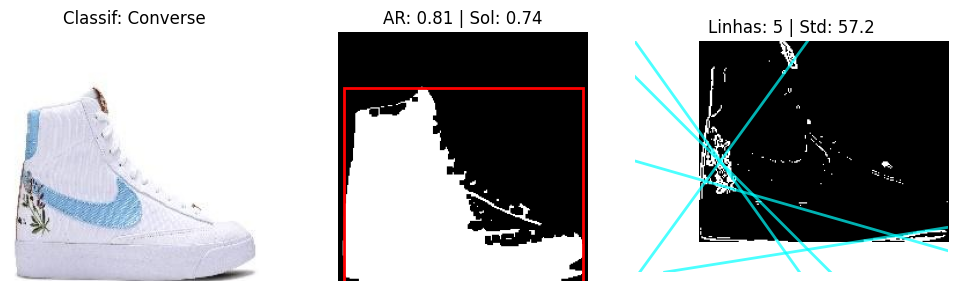


==================== Processando: Nike_03.jpg ====================
-> Aspect Ratio: 0.35 (Converse costuma ser > 0.60)
-> Solidez:      0.52     (Converse costuma ser > 0.65)
-> Linhas Hough: 6        (Adidas precisa >= 2)
-> Desvio Padrão:76.60     (Adidas precisa < 15.0)


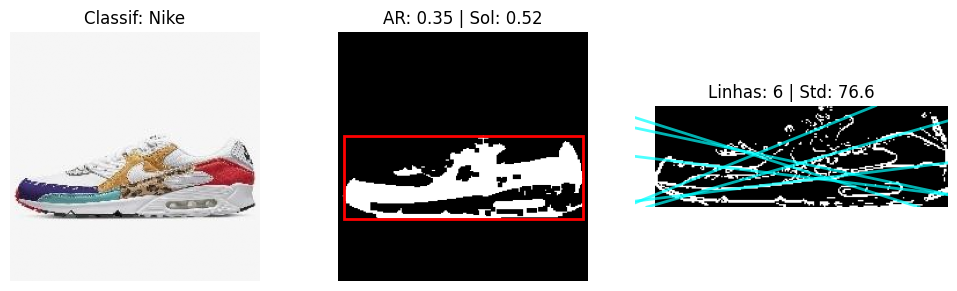


==================== Processando: Nike_05.jpg ====================
-> Aspect Ratio: 0.57 (Converse costuma ser > 0.60)
-> Solidez:      0.84     (Converse costuma ser > 0.65)
-> Linhas Hough: 7        (Adidas precisa >= 2)
-> Desvio Padrão:62.27     (Adidas precisa < 15.0)


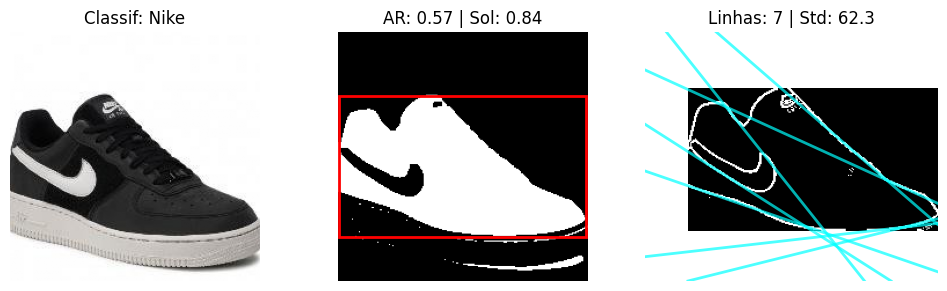


==================== Processando: Converse_04.jpg ====================
-> Aspect Ratio: 0.85 (Converse costuma ser > 0.60)
-> Solidez:      0.37     (Converse costuma ser > 0.65)
-> Linhas Hough: 32        (Adidas precisa >= 2)
-> Desvio Padrão:60.24     (Adidas precisa < 15.0)


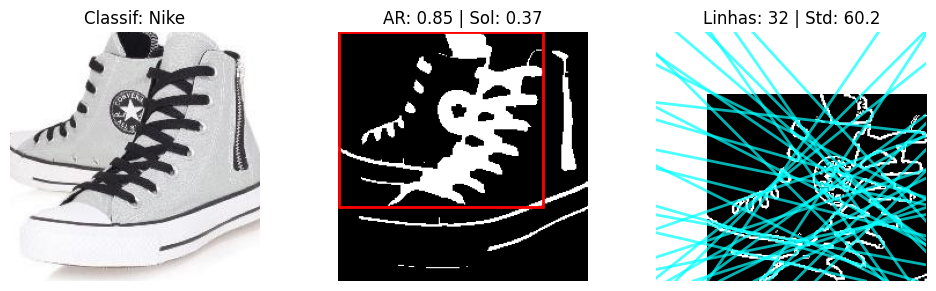


==================== Processando: Converse_03.jpg ====================
-> Aspect Ratio: 0.72 (Converse costuma ser > 0.60)
-> Solidez:      0.69     (Converse costuma ser > 0.65)
-> Linhas Hough: 2        (Adidas precisa >= 2)
-> Desvio Padrão:61.75     (Adidas precisa < 15.0)


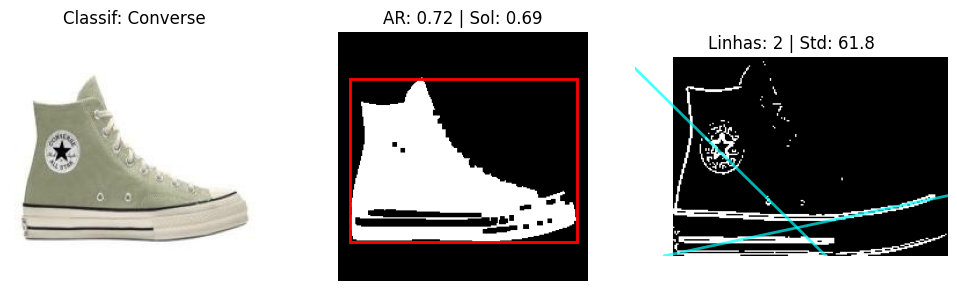


==================== Processando: Converse_06.jpg ====================
-> Aspect Ratio: 1.49 (Converse costuma ser > 0.60)
-> Solidez:      0.54     (Converse costuma ser > 0.65)
-> Linhas Hough: 12        (Adidas precisa >= 2)
-> Desvio Padrão:59.79     (Adidas precisa < 15.0)


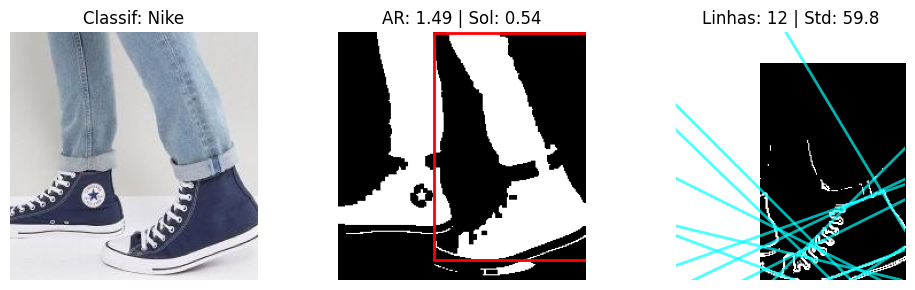


==================== Processando: Adidas_03.jpg ====================
-> Aspect Ratio: 0.41 (Converse costuma ser > 0.60)
-> Solidez:      0.43     (Converse costuma ser > 0.65)
-> Linhas Hough: 2        (Adidas precisa >= 2)
-> Desvio Padrão:64.75     (Adidas precisa < 15.0)


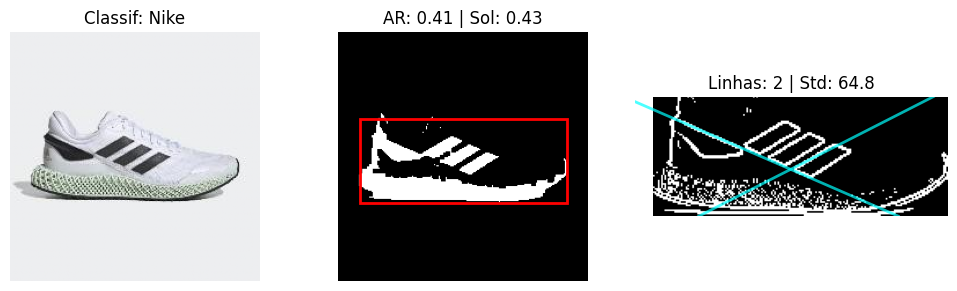


==================== Processando: Adidas_04.jpg ====================
-> Aspect Ratio: 0.19 (Converse costuma ser > 0.60)
-> Solidez:      0.22     (Converse costuma ser > 0.65)
-> Linhas Hough: 0        (Adidas precisa >= 2)
-> Desvio Padrão:999.00     (Adidas precisa < 15.0)


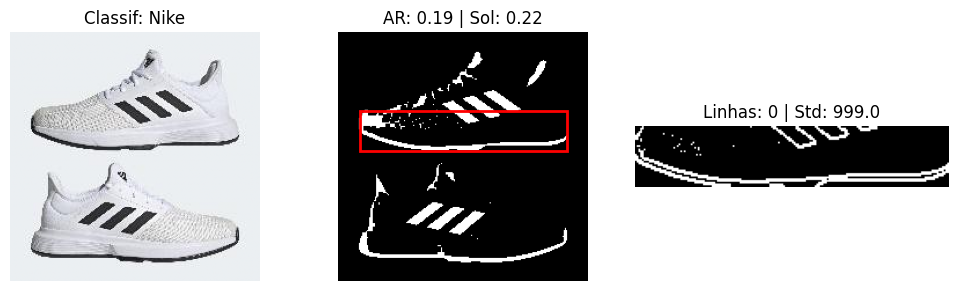


==================== Processando: Adidas_05.jpg ====================
-> Aspect Ratio: 0.74 (Converse costuma ser > 0.60)
-> Solidez:      0.78     (Converse costuma ser > 0.65)
-> Linhas Hough: 4        (Adidas precisa >= 2)
-> Desvio Padrão:40.29     (Adidas precisa < 15.0)


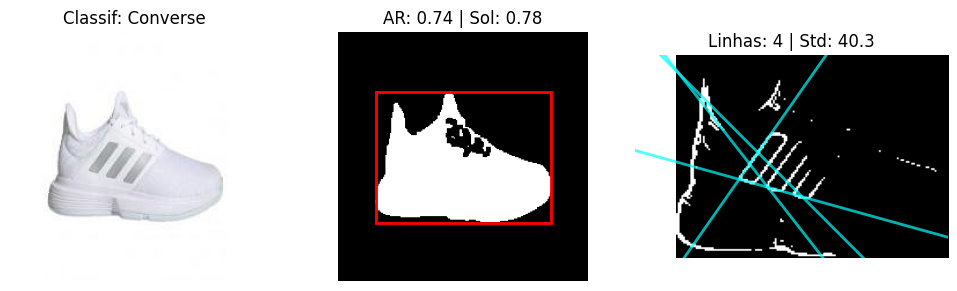

In [ ]:
def analyze_sneaker(image_path):
    filename = image_path.split('/')[-1]
    print(f"\n{'='*20} Processando: {filename} {'='*20}")

    try:
        raw_img = mpimg.imread(image_path)
    except:
        print("Erro arquivo.")
        return

    if raw_img.max() > 1.0: raw_img = raw_img / 255.0

    # CROP DE SEGURANÇA (Remove molduras pretas/bordas)
    # Removemos 5% de cada lado para garantir que só pegamos o miolo
    h_raw, w_raw = raw_img.shape[:2]
    margin = int(min(h_raw, w_raw) * 0.05)
    img = raw_img[margin:-margin, margin:-margin]

    gray = rgb2gray(img)

    # --- 1. BINARIZAÇÃO INTELIGENTE ---
    try:
        thresh = filters.threshold_otsu(gray)
    except:
        thresh = 0.5

    # Tenta binarizar assumindo fundo claro
    binary = gray < thresh

    # CORREÇÃO DE FUNDO:
    # Se a área branca for > 80% da imagem, provavelmente invertemos errado (pegamos o fundo)
    if np.sum(binary) > (binary.size * 0.80):
        binary = np.invert(binary) # Inverte para pegar o objeto escuro

    # Limpeza
    binary = morphology.binary_closing(binary, morphology.square(4))

    props = get_largest_object_props(binary)

    if props is None:
        print("Objeto não encontrado.")
        return

    # --- 2. EXTRAÇÃO DE DADOS ---
    solidity = props.solidity
    minr, minc, maxr, maxc = props.bbox
    height = maxr - minr
    width = maxc - minc
    aspect_ratio = height / width

    # --- 3. DETECÇÃO DE LINHAS (HOUGH) ---
    # Recorta apenas a bounding box para analisar listras
    shoe_crop = gray[minr:maxr, minc:maxc]

    # Sobel para detectar bordas
    edges = filters.sobel(shoe_crop)
    edges_bin = edges > (edges.max() * 0.3)

    num_lines, angle_std, debug_lines = analyze_stripes_parallelism(edges_bin)

    # --- DEBUG INFO ---
    print(f"-> Aspect Ratio: {aspect_ratio:.2f} (Converse costuma ser > 0.60)")
    print(f"-> Solidez:      {solidity:.2f}     (Converse costuma ser > 0.65)")
    print(f"-> Linhas Hough: {num_lines}        (Adidas precisa >= 2)")
    print(f"-> Desvio Padrão:{angle_std:.2f}     (Adidas precisa < 15.0)")

    # ============================================================
    # ÁRVORE DE DECISÃO V4.0 (Prioridade Adidas)
    # ============================================================

    label = "Desconhecido"

    # REGRA 1: ADIDAS TEM PRIORIDADE
    # Se tem listras paralelas, É ADIDAS. Não importa se o tênis é alto ou gordo.
    if num_lines >= 2 and angle_std < 15.0:
        label = "Adidas"
        reason = "Listras Paralelas Detectadas"

    # REGRA 2: CONVERSE
    # Se não tem listras, checamos se é alto e 'quadrado'
    elif aspect_ratio > 0.60 and solidity > 0.65:
        label = "Converse"
        reason = "Formato Alto e Sólido"

    # REGRA 3: NIKE
    # Sobra o resto (baixo, curvo, sem listras)
    else:
        label = "Nike"
        reason = "Perfil Baixo / Sem listras padrão"

    # ============================================================
    # VISUALIZAÇÃO
    # ============================================================
    plt.figure(figsize=(10, 3))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(f"Classif: {label}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(binary, cmap='gray')
    # O retângulo tem que bater com o tênis!
    rect = plt.Rectangle((minc, minr), width, height, edgecolor='r', facecolor='none', linewidth=2)
    plt.gca().add_patch(rect)
    plt.title(f"AR: {aspect_ratio:.2f} | Sol: {solidity:.2f}")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(edges_bin, cmap='gray')
    for angle, dist in debug_lines:
        (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
        plt.axline((x0, y0), slope=np.tan(angle + np.pi/2), color='cyan', alpha=0.7, linewidth=2)
    plt.title(f"Linhas: {num_lines} | Std: {angle_std:.1f}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# =============================================================================
# TESTE
# =============================================================================

imagens_teste = [
    "Nike_02.jpg",
    "Nike_03.jpg",
    "Nike_05.jpg",
    "Converse_04.jpg",
    "Converse_03.jpg",
    "Converse_06.jpg",
    "Adidas_03.jpg",
    "Adidas_04.jpg",
    "Adidas_05.jpg"
]

if not imagens_teste:
    print("⚠️ Lista vazia!")
else:
    for img_path in imagens_teste:
        analyze_sneaker(img_path)

# 1. Carregamento e Normalização da Imagem

Primeiro, carregamos a imagem. Para trabalhar com matemática de matrizes (multiplicações e limiares), é padrão normalizar os valores dos pixels de 0 a 255 (inteiros) para 0.0 a 1.0 (floats).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

img_raw = plt.imread('adidas2.jpg')

if img_raw.max() > 1: img = img_raw.astype(np.float32) / 255.0
else: img = img_raw.astype(np.float32)

# 2. O "Motor" Morfológico (Implementação Manual)

A morfologia funciona "passando" um molde (kernel) sobre a imagem.

**shift_vector:** Esta função auxiliar desloca a imagem inteira em uma direção (x, y). É uma forma vetorizada (rápida) de acessar os "vizinhos" de um pixel sem usar laços for lentos.

**erode_with_kernel (Erosão):** O pixel só permanece aceso se o molde (kernel) couber inteiramente dentro da área branca. Isso serve para "encolher" objetos ou eliminar ruídos que são menores que o molde.

**dilate_with_kernel (Dilatação):** O pixel acende se qualquer parte do molde tocar um pixel branco. Isso serve para "engordar" objetos ou fechar buracos.

In [ ]:
def shift_vector(im, dy, dx):
    res = np.roll(im, int(dy), axis=0)
    res = np.roll(res, int(dx), axis=1)
    if dy > 0: res[:int(dy), :] = 0
    elif dy < 0: res[int(dy):, :] = 0
    if dx > 0: res[:, :int(dx)] = 0
    elif dx < 0: res[:, int(dx):] = 0
    return res

def erode_with_kernel(img, kernel):
    rows, cols = kernel.shape
    cy, cx = rows // 2, cols // 2
    result = np.ones_like(img)
    for y in range(rows):
        for x in range(cols):
            if kernel[y, x] == 1:
                dy, dx = y - cy, x - cx
                shifted = shift_vector(img, -dy, -dx)
                result = np.minimum(result, shifted)
    return result

def dilate_with_kernel(img, kernel):
    rows, cols = kernel.shape
    cy, cx = rows // 2, cols // 2
    result = np.zeros_like(img)
    for y in range(rows):
        for x in range(cols):
            if kernel[y, x] == 1:
                dy, dx = y - cy, x - cx
                shifted = shift_vector(img, -dy, -dx)
                result = np.maximum(result, shifted)
    return result

# 3. Passo 1: Segmentação por Cor (Hardcoded)

Aqui aplicamos um filtro de cor específico para esta imagem.
Observamos que as listras são de uma cor "Teal" (Azul Petróleo). O tênis é branco e tem sombras cinzas.

**O Problema:** Sombras cinzas (como no calcanhar) têm valores baixos de RGB, mas equilibrados.

**A Solução:** Exigimos que o canal Azul (B) seja significativamente maior que o Vermelho (R) (B > R + 0.08). Isso preserva o azul das listras, mas elimina o cinza do calcanhar (onde B ≈ R).

In [ ]:
R = img[:,:,0]
G = img[:,:,1]
B = img[:,:,2]

mask_color = (R < 0.85) & (B > R + 0.08) & (G > 0.35)
binary = mask_color.astype(np.float32)

# 4. Passo 2: Filtro Geométrico (Abertura Diagonal)

A etapa de cor removeu o calcanhar, mas a sola do tênis também é azulada, então ela permaneceu.
Para remover a sola, usamos a geometria.

**Fato:** As listras são Diagonais (/). A sola é Horizontal (—).

**A Técnica:**

Criamos uma "régua" (kernel) diagonal. Tentamos encaixar essa régua dentro dos objetos brancos (Erosão).

Na sola, a régua diagonal não cabe (ela vaza para fora). A sola é apagada.

Nas listras, a régua cabe perfeitamente. Elas permanecem.

Em seguida, fazemos a Dilatação para restaurar o tamanho original das listras. Essa combinação (Erosão + Dilatação) chama-se Abertura Morfológica.

In [ ]:
# Criando a "Régua Diagonal"
# Aumentei levemente para 14px para garantir que limpe bem a sola
line_length = 14
kernel_diag = np.zeros((line_length, line_length))
np.fill_diagonal(np.flipud(kernel_diag), 1)

# APLICAÇÃO:
# 1. Erosão: Só sobra o que for diagonal E tiver a cor certa.
# A sola (que passou na cor) morre aqui porque é horizontal.
# O calcanhar (que é diagonal) já morreu na etapa de cor.
eroded = erode_with_kernel(binary, kernel_diag)

# 2. Dilatação: Restaura o tamanho das listras que sobraram
opened = dilate_with_kernel(eroded, kernel_diag)

# 5. Passo 3: Acabamento e Contorno

Agora que isolamos as listras, fazemos um acabamento estético:

**Fechamento (Close):** Uma dilatação seguida de erosão com um quadrado simples 3x3. Isso preenche pequenas falhas ou "buracos" dentro das listras.

**Gradiente Morfológico:** Calculamos Dilatação - Erosão. Isso gera uma linha fina exatamente na borda do objeto, que usamos para desenhar o contorno vermelho.

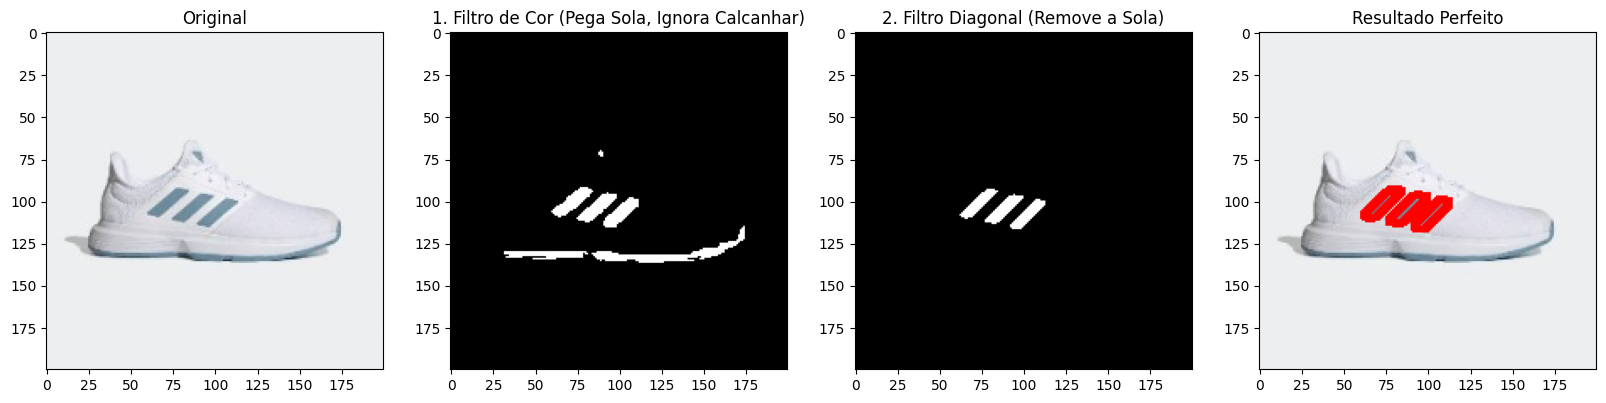

In [ ]:
# Fechamento simples (quadrado 3x3) para deixar as listras sólidas
k_simple = np.ones((3,3))
final_mask = dilate_with_kernel(opened, k_simple)
final_mask = erode_with_kernel(final_mask, k_simple)

# Gerar contorno
c_dilated = dilate_with_kernel(final_mask, k_simple)
c_eroded = erode_with_kernel(final_mask, k_simple)
contours = c_dilated - c_eroded

# =========================================================
# VISUALIZAÇÃO
# =========================================================
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].imshow(img)
ax[0].set_title("Original")

ax[1].imshow(binary, cmap='gray')
ax[1].set_title("1. Filtro de Cor (Pega Sola, Ignora Calcanhar)")

ax[2].imshow(opened, cmap='gray')
ax[2].set_title("2. Filtro Diagonal (Remove a Sola)")

# Resultado Final
overlay = img.copy()
# Engrossar o contorno para visualização (usando dilatação no contorno)
contours_thick = dilate_with_kernel(contours, np.ones((3,3)))
overlay[contours_thick > 0] = [1, 0, 0] # Vermelho

ax[3].imshow(overlay)
ax[3].set_title("Resultado Perfeito")

plt.show()